# Tutorial 22: Data-driven corrections in SUP-ROM

## Importing full order data and POD output before online simulation

We import useful modules and set the torch and numpy seeds:

In [31]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import fsolve
#file which contains the model for the neural network used to reconstruct the eddy viscosity coefficients:
import TrainNet  
from sklearn.model_selection import train_test_split
from scipy.linalg import svdvals
from sklearn import preprocessing
import os.path
from scipy.interpolate import Rbf
from os import path
from scipy.interpolate import griddata
from sklearn.utils.extmath import randomized_svd
from matplotlib.ticker import MaxNLocator
import math
from sklearn import *
import cvxpy as cp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'STIXGeneral',
    'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'font.size': 16})

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

We here define a function to read the matrices data files.

In [32]:
def readFile(fileName):
    fileObj = open(fileName, "r") #opens the file in read mode
    words = fileObj.read().splitlines() #puts the file into an array
    words.pop(0); words.pop(0)
    words = [float(i) for i in words]
    fileObj.close()
    return words

Then, the matrices and tensors evaluated starting from the POD modes and stored folder *DataSUP* are here imported.

In [33]:
B = np.load("DataSUP/B.npy")
Bt = np.load("DataSUP/bt.npy")
M = np.load("DataSUP/M.npy")
C = np.load("DataSUP/C.npy")
K = np.load("DataSUP/K.npy")
P = np.load("DataSUP/P.npy")
Ct1 = np.load("DataSUP/ct1.npy")
Ct2 = np.load("DataSUP/ct2.npy")
coeffU = np.load("DataSUP/coeefs.npy") #100 modes x 5001 time steps
coeffP = np.load("DataSUP/coeefsP.npy") #50 modes x 5001 time steps
coeffNut = np.load("DataSUP/coeefsNut.npy")
bcMat = np.load("DataSUP/bcMat.npy")
bcVec = np.load("DataSUP/bcVec.npy")
CtTot = Ct1 + Ct2 

Also the full snapshots for pressure, velocity and supremizer fields are loaded here, from folder *DataSUP*. Since the computational grid is composed by 11644 cells, and the online simulation lasts 5001 time steps, the dimension of the pressure snapshots is 11644 x 5001. The dimension of the velocity and supremizer snapshots is 34932 x 5001, since the three components of velocities are row-wise concatenated. Just 50 modes are exported and saved here.

In [34]:
Eig_U = readFile("DataSUP/Eigenvalues_U")
coo = np.load("DataSUP/coo.npy")
modU = np.load("DataSUP/modU.npy") #34932x50
modSup = np.load("DataSUP/modSup.npy")  #34932x50
modP = np.load("DataSUP/modP.npy") #11644x50
snapU = np.load("DataSUP/snapU.npy")   #34932x50
snapSup = np.load("DataSUP/snapSup.npy")  #34932x50
snapP = np.load("DataSUP/snapP.npy") #11644x50

## Definition of the SUP-ROM class: online stage

Now the ROM class is defined. Here the data-driven correction terms are computed and the reduced system including these extra-terms is defined. The reduced dynamical system is solved in two different cases: with and without the eddy-viscosity turbulence modelling. 

We here choose a reduced number of velocity, supremizer and pressure modes ($N_u, N_{sup}$ and $N_p$, respectively) for the reduced model. The modes are denoted as: $(\boldsymbol{\phi_i})_{i=1}^{N_u+N_{sup}}$ and $(\chi_i)_{i=1}^{N_p}$.

The projections of the full order fields onto the subspace generated by these modes are:

\begin{equation}
\mathbf{\bar{u}}_r = \sum_{i=1}^{N_u+N_{sup}} a^{snap}_i \boldsymbol{\phi_i} \text{ and } \bar{p}_r = \sum_{i=1}^{N_u+N_{sup}} b^{snap}_i \chi_i,
\end{equation}
where the matrices of the coefficients $a^{snap}_i$ and $b^{snap}_i$ are evaluated from the POD and stored in the snapshots matrices *snapU*, *snapSup* and *snapP*.

The reduced approximated fields are computed at each time step by solving a dynamical system with unknowns $\mathbf{a}=(a_i)_{i=1}^{N_u+N_{sup}}$ and $\mathbf{b}=(b_i)_{i=1}^{N_p}$, which are the vectors of coefficients for velocity and pressure. The reduced approximated fields are defined as:
\begin{equation}
\mathbf{u}_r = \sum_{i=1}^{N_u+N_{sup}} a_i(t) \boldsymbol{\phi_i} \text{ and } \bar{p}_r = \sum_{i=1}^{N_u+N_{sup}} b_i(t) \chi_i
\end{equation}


The supremizer reduced system, obtained with a POD-Galerkin approach with the addition of extra correction terms, is the following:
\begin{equation}
    \begin{cases}
    \mathbf{M} \dot{\mathbf{a}}=\nu(\mathbf{B}+\mathbf{B_T})\mathbf{a}-\mathbf{a}^T \mathbf{C} \mathbf{a}-\mathbf{H}\mathbf{b}+\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right) + \boldsymbol{\tau}_u(\mathbf{a}),\\
    \mathbf{P}\mathbf{a}=\mathbf{0}.
    \end{cases}
\end{equation}

Matrices appearing in the previous system are defined as:
\begin{equation}
\begin{split}
&(\mathbf{M})_{ij}=(\boldsymbol{\phi}_i,\boldsymbol{\phi}_j)_{L^2(\Omega)}, \quad (\mathbf{P})_{ij}=(\chi_i,\nabla \cdot \boldsymbol{\phi}_j)_{L^2(\Omega)}\, ,\quad (\mathbf{B})_{ij}=(\boldsymbol{\phi}_i,\nabla \cdot \nabla \boldsymbol{\phi}_j)_{L^2(\Omega)}, \\
&(\mathbf{B_T})_{ij}=(\boldsymbol{\phi}_i,\nabla \cdot (\nabla \boldsymbol{\phi}_j)^T)_{L^2(\Omega)},\quad (\mathbf{C})_{ijk}=(\boldsymbol{\phi}_i,\nabla \cdot (\boldsymbol{\phi}_j \otimes \boldsymbol{\phi}_k))_{L^2(\Omega)}, \quad (\mathbf{H})_{ij}=(\boldsymbol{\phi}_i,\nabla \chi_j)_{L^2(\Omega)}\, .
\end{split}
\end{equation}

The term $\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right)$ is a penalization term used to enforce the Dirichlet boundary conditions at the reduced order level. In particular, $N_{\text{BC}}$ is the number of velocity boundary conditions on $k $ different parts of the Dirichlet boundary; $U_{\text{BC},k}$ is the velocity non-zero component at the $k$-th part of the Dirichlet boundary; $\tau$ is a penalization factor, matrices $\mathbf{E}^k$ and vectors $\mathbf{D}^k$ are defined as:
\begin{equation} (\mathbf{E}^k)_{ij}=(\boldsymbol{\phi}_i, \boldsymbol{\phi}_j)_{L^2(\Gamma_{D_k})}, \quad (\mathbf{D}^k)_{i}=(\boldsymbol{\phi}_i)_{\Gamma_{D_k}}, \text{ for all }k=1,...,N_{\text{BC}}.\end{equation}

The time derivative is computed with a second order backward time scheme.

In the first equation the term $\boldsymbol{\tau^u}(\mathbf{a})$ is a velocity correction term evaluated as follows.

1. First of all, the exact correction term is found from available data, at each time step:

$\boldsymbol{\tau}_u^{\text{exact}}(t_j)=\left(- \overline{(\mathbf{a}_d^{snap}(t_j))^T\mathbf{C_d}\mathbf{a}_d^{snap}(t_j)}^r\right) -\left(-(\mathbf{a}_r^{snap}(t_j))^T\mathbf{C}\mathbf{a}_r^{snap}(t_j) \right)\, , $
where the tensor $\mathbf{C_d} \in \mathbb{R}^{d \times d \times d}$ is defined in the following way:
$
\mathbf{C_d}_{\,ijk}=\left(\boldsymbol{\phi}_i, \nabla \cdot (\boldsymbol{\phi}_j \otimes \boldsymbol{\phi}_k) \right).
$

2. Then, an ansatz is proposed to model the approximated correction term:

\begin{equation}
\boldsymbol{\tau}_u^{\text{ansatz}}(t_j)=\tilde{A}\mathbf{a}(t_j)+(\mathbf{a}(t_j))^T\tilde{B}\mathbf{a}(t_j),
\end{equation}
where the unknwons are matrices $\tilde{A}$ and $\tilde{B}$.

3. The matrices and tensors appearing in the ansatz are computed by solving an optimization problem, which is rewritten as a least squares problem between the exact and the approximated term. In this tutorial, we are considering a costrained least squares problem, with physical energetical constraints.

\begin{equation}
    \min_{\substack{\tilde{A} \in \mathbb{R}^{r \times r},\\ \tilde{B} \in \mathbb{R}^{r \times r \times r},\\ \mathbf{a} \tilde{A} \mathbf{a} \leq 0,\\\mathbf{a}^T(\mathbf{a}^T \tilde{B} \mathbf{a})=0}}{\sum_{j=1}^{M_1} || \boldsymbol{\tau}_u^{\text{exact}}(t_j)-\boldsymbol{\tau}_u^{\text{ansatz}}(t_j)||_{L^2(\Omega)}^2} .
\end{equation}

It is important to remark that the number of time steps used to compute the correction terms is 500 (2 seconds), whereas the online simulation lasts 5001 time steps (8 seconds). 

The least squares problem which is obtained is written in the following way:

\begin{equation}
    \min_{\mathbf{O}}{||\mathbf{R}-\mathbf{D}\mathbf{O}^T||^2_F} ,
\end{equation}
where:
\begin{equation}
\mathbf{R}_{j,\cdot}=\mathbf{\tau_u}^{\text{exact}}(t_j) \quad \forall j=1,...M, \quad \mathbf{O}=[\tilde{A},\tilde{B}^{(1)}, \tilde{B}^{(2)},...,\tilde{B}^{(r)}], \text{ with } \tilde{B}^{(i)} \text{ i-th blocks of tensor } \tilde{B},
\end{equation}
\begin{equation}
\mathbf{D}=[\hat{X}, \hat{X}^{(1)}, \hat{X}^{(2)},..., \hat{X}^{(r)}], \text{ with:} 
\end{equation}
- $\hat{X}_{j,\cdot}=\mathbf{a}_r^{\text{snap}}(t_j)$, which is the j-th row of matrix $\hat{X}$;
- $\mathbf{a}^{(i)}(t_j)=a^{\text{snap}}_i(t_j) \begin{bmatrix}a_0^{\text{snap}}(t_j)\\a_1^{\text{snap}}(t_j)\\...\\a_i^{\text{snap}}(t_j)
    \end{bmatrix} \in \mathbb{R}^i \text{ for }i=1,...,r$;
- $\hat{X}^{(i)}_{j,\cdot}=\mathbf{a}^{(i)}(t_j)$, which is the j-th row of matrix $\hat{X}^{(i)}$, with $i=1,...,r$.

Matrix $\mathbf{D}$ in the least squares problem is ill-conditioned and in order to solve this problem a truncated singular value decoposition is applied to the matrix. The number of singular values retained in this truncated SVD is chosen at the one that optimizes a velocity error metric $\varepsilon_u$ *a posteriori*. The error metric considered is:

\begin{equation}
    \varepsilon_u (L^2)= \sum_{j=1}^M ||\mathbf{u}_{\text{sol}}(t_j)-\mathbf{u}_r(t_j)||_{L^2(\Omega)} ,
    \label{error_metric}
\end{equation}
where $M$ is the number of time steps considered for the online simulation (2000 in our case, which corresponds to 8 seconds).

In the ROM class another reduced formulation is also considered, where the turbulence modelling is added, making use of an eddy viscosity model. 
In this model, there is an extra-term depending on the eddy viscosity $\nu_t$, which is modelled as a linear combination of eddy viscosity modes $(\eta_i)_{i=1}^{N_{\nu_t}}$. The reduced eddy viscosity field is expressed as:

\begin{equation}
\nu_{t, r} = \sum_{i=1}^{N_{\nu_t}} g_i(t) \eta_i
\end{equation}

The reduced number of modes chosen for the eddy viscosity is the same of the velocity modes in our case ($N_{\nu_t}=N_u$). 

The reduced vector of coefficients $\mathbf{g}=(g_i)_{i=1}^{N_{\nu_t}}$ is computed at each time step with a regression technique starting from vector $\mathbf{a}$. 
In this case, $\mathbf{g}$ is computed making use of a feed-forward neural network, which is trained with the pairs of snapshots $(\mathbf{a}^{snap}, \mathbf{g}^{snap})$.

The reduced system written before can be rewritten in the following way:
\begin{equation}
\begin{cases}
    &\mathbf{M}\dot{\mathbf{a}} = \nu (\mathbf{B}+\mathbf{B_T}) \mathbf{a} - \mathbf{a}^T \mathbf{C} \mathbf{a} + \mathbf{g}^T (\mathbf{C}_{\text{T1}}+\mathbf{C}_{\text{T2}}) \mathbf{a} - \mathbf{H} \mathbf{b}+\tau \left( \sum_{k=1}^{N_{\text{BC}}}(U_{\text{BC},k}\mathbf{D}^k-\mathbf{E}^k \mathbf{a})\right) + \boldsymbol{\tau}^u(\mathbf{a}) \, ,\\
    &\mathbf{P} \mathbf{a}=\mathbf{0} \, ,
    \end{cases}
\end{equation}
where the new tensors are defined as follows.
\begin{equation}
    \begin{cases}
    &(\mathbf{C}_{\text{T1}})_{ijk}=(\boldsymbol{\phi}_i, \eta_j \nabla \cdot \nabla \boldsymbol{\phi}_k)_{L^2(\Omega)} \, ,\\
    &(\mathbf{C}_{\text{T2}})_{ijk}=(\boldsymbol{\phi}_i, \nabla \cdot \eta_j (\nabla \boldsymbol{\phi}_k)^T)_{L^2(\Omega)}\, .
    \end{cases}
\end{equation}


Here, the class ROM includes the computation of the two dynamical systems, without and with the eddy-viscosity modelling.

Some error metrics are also defined in this class, i.e., *errors*, which contains the percentage errors of the reduced velocity and pressure fields, at each time step, in the $L^2$ norm, with respect to the projected fields and the full order fields.

*U_proj* and *P_proj* compute the reconstruction percentage errors, which are defined as the errors of the projected fields and the full order solutions and represent the best possible result that can be achieved.

In [45]:
class ROM():
    def __init__(self, _Nu, _Nsup, _Np, _Nnut, _Ru):
        #Sizes
        self.Nu = _Nu
        self.Nsup = _Nsup
        self.Np = _Np
        self.Nnut = _Nnut  
        self.M = 2001
        self.M1 = 500
        self.Nu_tot = 50
        self.Nsup_tot = 50
        self.Np_tot = 50
        self.Nnut_tot = 50
        self.Ru = _Ru
        self.timeOnline = []
        self.dtOn = []
        self.ntOn = []
        self.sol = []
        self.Net = []
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []     
        self.inp_np_train = []  
        self.inp_np_test = []  
        self.out_np_train = []  
        self.out_np_test = []  
        self.scaling = []
        self.trainset = []
        self.testset = []
        self.trainloader = []
        self.testloader = []
        self.loss_fn = []
        self.lossplottrain = []
        self.lossplottest = []
        self.tplot = []
        self.device = torch.device('cpu')
        self.gsol = []
        self.BC = 5
        self.tau = 1000
        self.errU_proj = np.zeros(self.M)
        self.errU_full = np.zeros(self.M)
        self.errP_proj = np.zeros(self.M)
        self.errP_full = np.zeros(self.M)
        
        #nu 
        self.nu = 1e-4
        
        self.CumEig_U = readFile("DataSUP/CumEigenvalues_U")
        self.CumEig_Usup = readFile("DataSUP/CumEigenvalues_Usup")
        self.CumEig_P = readFile("DataSUP/CumEigenvalues_P")
        
        ## Import useful data from FOM simulation
#        self.coo = coo[:,0:2]
        self.coeff_Ux = snapU[0:11644,:]
        self.coeff_Uy = snapU[11644:23288,:]         
        self.coeff_Uz = snapU[23288:34932,:]
        self.mod_Ux = modU[0:11644,:]
        self.mod_Uy = modU[11644:23288,:]         
        self.mod_Uz = modU[23288:34932,:]
        self.coeffsup_Ux = snapSup[0:11644,:]
        self.coeffsup_Uy = snapSup[11644:23288,:]         
        self.coeffsup_Uz = snapSup[23288:34932,:]
        self.modsup_Ux = modSup[0:11644,:]
        self.modsup_Uy = modSup[11644:23288,:]         
        self.modsup_Uz = modSup[23288:34932,:]
        self.P_full = snapP
        self.mod_P = modP
        self.coeffU = coeffU
        self.coeffP = coeffP
        self.EigU = Eig_U
        
        ## Computing the velocity magnitude at each time step and for 
        ## each node (considering Nu_tot modes)      
        U_x50 = np.zeros((11644,self.M))
        U_y50 = np.zeros((11644,self.M))
        U_z50 = np.zeros((11644,self.M))
        self.U_norm_50 = np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Nu_tot):
                U_x50[:,i] = U_x50[:,i]+self.coeffU[j,i]*self.mod_Ux[:,j]
                U_y50[:,i] = U_y50[:,i]+self.coeffU[j,i]*self.mod_Uy[:,j]
                U_z50[:,i] = U_z50[:,i]+self.coeffU[j,i]*self.mod_Uz[:,j]
            for m in range(self.Nsup_tot):
                U_x50[:,i] = U_x50[:,i]+self.coeffU[self.Nu_tot+m,i]*self.modsup_Ux[:,m]
                U_y50[:,i] = U_y50[:,i]+self.coeffU[self.Nu_tot+m,i]*self.modsup_Uy[:,m]
                U_z50[:,i] = U_z50[:,i]+self.coeffU[self.Nu_tot+m,i]*self.modsup_Uz[:,m]
            self.U_norm_50[:,i] = np.sqrt(U_x50[:,i]**2+U_y50[:,i]**2+U_z50[:,i]**2)
            
                 
        ## Computing the velocity magnitude at each time step and for each node 
        ## (considering Nu modes)      
        U_x10 = np.zeros((11644,self.M))
        U_y10 = np.zeros((11644,self.M))
        U_z10 = np.zeros((11644,self.M))
        self.U_norm_10 = np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Nu):
                U_x10[:,i] = U_x10[:,i]+self.coeffU[j,i]*self.mod_Ux[:,j]
                U_y10[:,i] = U_y10[:,i]+self.coeffU[j,i]*self.mod_Uy[:,j]
                U_z10[:,i] = U_z10[:,i]+self.coeffU[j,i]*self.mod_Uz[:,j]
            for m in range(self.Nsup):
                U_x10[:,i] = U_x10[:,i]+self.coeffU[self.Nu_tot+m,i]*self.modsup_Ux[:,m]
                U_y10[:,i] = U_y10[:,i]+self.coeffU[self.Nu_tot+m,i]*self.modsup_Uy[:,m]
                U_z10[:,i] = U_z10[:,i]+self.coeffU[self.Nu_tot+m,i]*self.modsup_Uz[:,m]
            self.U_norm_10[:,i] = np.sqrt(U_x10[:,i]**2+U_y10[:,i]**2+U_z10[:,i]**2)
            
        ## Pressure value at each time step and for each node 
        ## (considering Np_tot modes)
        self.P_50 = np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Np_tot):
                self.P_50[:,i] = self.P_50[:,i]+self.coeffP[j,i]*self.mod_P[:,j]
                
        ## Pressure value at each time step and for each node 
        ##(considering Np modes)
        self.P_10 = np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Np):
                self.P_10[:,i] = self.P_10[:,i]+self.coeffP[j,i]*self.mod_P[:,j]
        
        ## Slice Matrices according to dimension
        self.B_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.B_ok[0:self.Nu,0:self.Nu] = B[0:self.Nu,0:self.Nu]
        self.B_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = B[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.B_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu] = B[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.B_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup] = B[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.Bt_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.Bt_ok[0:self.Nu,0:self.Nu] = Bt[0:self.Nu,0:self.Nu]
        self.Bt_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = Bt[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.Bt_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu] = Bt[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.Bt_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup] = Bt[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.M_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.M_ok[0:self.Nu,0:self.Nu] = M[0:self.Nu,0:self.Nu]
        self.M_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = M[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.M_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu] = M[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.M_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup] = M[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.K_ok = np.zeros([self.Nu+self.Nsup,self.Np])
        self.K_ok[0:self.Nu,0:self.Np] = K[0:self.Nu,0:self.Np]
        self.K_ok[self.Nu:self.Nu+self.Nsup,0:self.Np] = K[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Np]

        self.C_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.C_ok[0:self.Nu,0:self.Nu,0:self.Nu] = C[0:self.Nu,0:self.Nu,0:self.Nu]
        self.C_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = C[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.C_ok[0:self.Nu,0:self.Nu,self.Nu:self.Nu+self.Nsup] = C[0:self.Nu,0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.C_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = C[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.C_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup,0:self.Nu] = C[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.C_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu,0:self.Nu] = C[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu,0:self.Nu]
        self.C_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup,0:self.Nu] = C[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.C_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu,self.Nu:self.Nu+self.Nsup] = C[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.P_ok = np.zeros([self.Np,self.Nu+self.Nsup])
        self.P_ok[0:self.Np,0:self.Nu] = P[0:self.Np,0:self.Nu]
        self.P_ok[0:self.Np,self.Nu:self.Nu+self.Nsup] = P[0:self.Np,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.CtTot_Ok = np.zeros([self.Nu+self.Nsup,self.Nnut,self.Nu+self.Nsup])
        self.CtTot_Ok[0:self.Nu,0:self.Nnut,0:self.Nu] = CtTot[0:self.Nu,0:self.Nnut,0:self.Nu]
        self.CtTot_Ok[self.Nu:self.Nu+self.Nsup,0:self.Nnut,self.Nu:self.Nu+self.Nsup] = CtTot[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nnut,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.CtTot_Ok[0:self.Nu,0:self.Nnut,self.Nu:self.Nu+self.Nsup] = CtTot[0:self.Nu,0:self.Nnut,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.CtTot_Ok[self.Nu:self.Nu+self.Nsup,0:self.Nnut,0:self.Nu] = CtTot[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nnut,0:self.Nu]
        self.CtTot_Ok[self.Nu:self.Nu+self.Nsup,0:self.Nnut,self.Nu:self.Nu+self.Nsup] = CtTot[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nnut,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.coeffU_ok = np.zeros([self.Nu+self.Nsup,coeffU.shape[1]])
        self.coeffNut_ok = coeffNut[0:self.Nnut,:]
        self.coeffP_ok = coeffP[0:self.Np,:]
        self.coeffU_ok[0:self.Nu,:] = coeffU[0:self.Nu,:]
        self.coeffU_ok[self.Nu:self.Nu+self.Nsup,:] = coeffU[self.Nu_tot:self.Nu_tot+self.Nsup,:]
        
        self.bcMat_ok = np.zeros([self.Nu+self.Nsup,self.Nu+self.Nsup])
        self.bcMat_ok[0:self.Nu,0:self.Nu] = bcMat[0:self.Nu,0:self.Nu]
        self.bcMat_ok[self.Nu:self.Nu+self.Nsup,self.Nu:self.Nu+self.Nsup] = bcMat[self.Nu_tot:self.Nu_tot+self.Nsup,self.Nu_tot:self.Nu_tot+self.Nsup]
        self.bcMat_ok[self.Nu:self.Nu+self.Nsup,0:self.Nu] = bcMat[self.Nu_tot:self.Nu_tot+self.Nsup,0:self.Nu]
        self.bcMat_ok[0:self.Nu,self.Nu:self.Nu+self.Nsup] = bcMat[0:self.Nu,self.Nu_tot:self.Nu_tot+self.Nsup]

        self.bcVec_ok = np.zeros([self.Nu+self.Nsup])
        self.bcVec_ok[0:self.Nu] = bcVec[0:self.Nu]
        self.bcVec_ok[self.Nu:self.Nu+self.Nsup] = bcVec[self.Nu_tot:self.Nu_tot+self.Nsup]
        
        #Times
        self.dtOff = 0.004
        self.ntOff = 5000
        self.timeOffline = np.linspace(20,20+self.ntOff*self.dtOff,self.ntOff+1)
        
        
        ## Definition of the term tau exact for velocity
        term1 = np.zeros((self.Nu_tot,self.M1))
        term2 = np.zeros((self.Nu,self.M1))
        self.tau_ex_U = np.zeros((self.Nu,self.M1))
        Xhat_Ut = np.zeros((self.Nu,self.M1))
        
        for j in range(self.M1):
            term1[:,j] = - np.transpose(coeffU[0:self.Nu_tot,j])@C[0:self.Nu_tot,0:self.Nu_tot,0:self.Nu_tot]@(coeffU[0:self.Nu_tot,j])
            term2[:,j] = - np.transpose(self.coeffU_ok[0:self.Nu,j])@self.C_ok[0:self.Nu,0:self.Nu,0:self.Nu]@(self.coeffU_ok[0:self.Nu,j])
            self.tau_ex_U[:,j] = term1[0:self.Nu,j]-term2[:,j]
            Xhat_Ut[:,j] = self.coeffU_ok[0:self.Nu,j] #Nu x M1 --> Xhat is M1 x Nu
            
        self.tau_ex_U = self.tau_ex_U.T
        Xhat_U = Xhat_Ut.T
        
        ## Construction of the least squares problem for velocity correction WITH CONSTRAINTS
        Dmat_U = np.zeros((self.M1,self.Nu))
        Dmat_U[:,0:self.Nu] = Xhat_U  #initialization of matrix D
        
        for i in range(1,self.Nu+1,1):
            Xhat_Ui = np.zeros((self.M1,i))
            
            for j in range(self.M1):
                Xhat_Ui[j,0:i] = np.dot(Xhat_U[j,i-1],Xhat_U[j,0:i])
            
            Dmat_U = np.append(Dmat_U,Xhat_Ui,axis=1)
            
        elements2 = np.linspace(1,self.Nu,self.Nu)
        rows2 = sum(elements2)+ self.Nu
        self.rows2 = int(rows2)
            
        ## Truncated SVD and resolution of the least square problem for constrained data-driven correction
    
        O_vel = np.zeros((self.rows2,self.Nu)) 
        U_vel,S_vel,VT_vel = scipy.linalg.svd(Dmat_U,full_matrices=False) #full svd 

        Sigma_vel = np.diag(S_vel[0:self.Ru])  
        U_vel = U_vel[:,0:self.Ru]
        VT_vel = VT_vel[0:self.Ru,:]
        Dmat_Unew = U_vel@Sigma_vel@VT_vel    #truncated SVD
               
        for i in range(self.Nu):
            o_ic = cp.Variable(self.rows2)
            objective = cp.Minimize(cp.sum_squares(Dmat_Unew@o_ic-self.tau_ex_U[:,i]))
            quad_term = np.zeros(self.M1)
            k = self.Nu
            for m in range(1,self.Nu+1,1):
                Btilde_m = o_ic[k:k+m]
                Xhat_m = Dmat_Unew[:,k:k+m]
                k = k+m
                quad_term = quad_term+Xhat_m@Btilde_m
            constraints = [Xhat_U.T@Dmat_Unew[:,0:self.Nu]@o_ic[0:self.Nu]<=0, Xhat_U.T@quad_term==0]
            prob = cp.Problem(objective,constraints)
            prob.solve()
            O_vel[:,i] = o_ic.value
            
        self.Omat_c = O_vel.T
        self.Atilde = self.Omat_c[:,0:self.Nu] #the matrix Atilde to use in the computation of the residual
        self.Btilde = self.Omat_c[:,self.Nu:self.rows2]
            
    # Solve the online problem with correction term, without turbulence modelling
    def solveOnline(self, _dtOn, _ntOn):
        self.dtOn = _dtOn
        self.ntOn = _ntOn
        self.timeOnline = np.linspace(20,20+self.ntOn*self.dtOn,self.ntOn)
        self.a_0 = self.coeffU_ok[:,0]
        self.a = self.a_0
        self.b_0 = self.coeffP_ok[:,0]
        self.ab_0 = np.concatenate((self.a_0,self.b_0))
        self.a_old = self.a_0
        self.b_old = self.b_0
        
        ab = self.ab_0
        a = self.a_0
        self.i = 0
        for i,t in enumerate(self.timeOnline):
            self.i  =i
            
            if i == 0:
                self.sol = ab.reshape(-1,1)
                ab = fsolve(self.residual0, ab)
            if i == 1:
                self.sol = ab.reshape(-1,1)
                ab = fsolve(self.residual0, ab)
                
            else:
                self.sol = np.hstack((self.sol,ab.reshape(-1,1)))
                ab = fsolve(self.residual, ab)
            self.a_old = ab[0:self.Nu+self.Nsup]
            self.b_old = ab[self.Nu+self.Nsup:self.Np+self.Nu+self.Nsup]
            
    # Solve the standard online problem
    def solveOnline_standard(self, _dtOn, _ntOn):
        self.dtOn = _dtOn
        self.ntOn = _ntOn
        self.timeOnline = np.linspace(20,20+self.ntOn*self.dtOn,self.ntOn)
        self.a_0 = self.coeffU_ok[:,0]
        self.a = self.a_0
        self.b_0 = self.coeffP_ok[:,0]
        self.ab_0 = np.concatenate((self.a_0,self.b_0))
        self.a_old = self.a_0
        self.b_old = self.b_0
        
        ab = self.ab_0
        a = self.a_0
        self.i = 0
        for i,t in enumerate(self.timeOnline):
            self.i = i
            if i == 0:
                self.sol = ab.reshape(-1,1)
                ab = fsolve(self.residual0_stand, ab)
            if i == 1:
                self.sol = ab.reshape(-1,1)
                ab = fsolve(self.residual0_stand, ab)
            else:
                self.sol = np.hstack((self.sol,ab.reshape(-1,1)))
                ab = fsolve(self.residual_stand, ab)
            self.a_old = ab[0:self.Nu+self.Nsup]
            self.b_old = ab[self.Nu+self.Nsup:self.Np+self.Nu+self.Nsup]
                

    # Solve the online problem with turbulence modelling and including the velocity correction
    def solveOnlineT(self, _dtOn, _ntOn):
        self.dtOn = _dtOn
        self.ntOn = _ntOn
        self.timeOnline = np.linspace(20,20+self.ntOn*self.dtOn,self.ntOn)
        self.a_0 = self.coeffU_ok[:,0]
        self.a = self.a_0
        self.b_0 = self.coeffP_ok[:,0]
        self.g_0 = self.coeffNut_ok[:,0]
        self.ab_0 = np.concatenate((self.a_0,self.b_0))
        self.a_old = self.a_0
        self.b_old = self.b_0
        
        ab = self.ab_0
        a = self.a_0
        self.i = 0
        for i,t in enumerate(self.timeOnline):
            self.i = i
            if i == 0:
                self.sol = ab.reshape(-1,1)
                self.gsol = self.g_w(ab).reshape(-1,1)
                ab = fsolve(self.residualT0, ab)
            if i == 1:
                self.sol = ab.reshape(-1,1)
                self.gsol = self.g_w(ab).reshape(-1,1)
                ab = fsolve(self.residualT0, ab)
            
            else:
                self.sol = np.hstack((self.sol,ab.reshape(-1,1)))
                self.gsol = np.hstack((self.gsol,self.g_w(ab).reshape(-1,1)))
                ab = fsolve(self.residualT, ab)
            self.a_old = ab[0:self.Nu+self.Nsup]
            self.b_old = ab[self.Nu+self.Nsup:self.Np+self.Nu+self.Nsup]
            
     
    # Residual without turbulence modelling and with correction for initial time steps
    def residual0(self,ab):
        res0 = ab*0
        a = ab[0:self.Nu+self.Nsup]
        a_nu = a[0:self.Nu]
        b = ab[self.Nu+self.Nsup:self.Nu+self.Nsup+self.Np]
        adot0 = (a-self.a_old)/self.dtOn
        A_term = np.zeros(self.Nu+self.Nsup)
        A_term[0:self.Nu] = self.Atilde@a_nu
        
        B_term = np.zeros(self.Nu+self.Nsup)
        ku = 0
        for i in range(1,self.Nu+1,1):
            a_i = np.zeros(i)
            a_i[0:i] = np.dot(a_nu[i-1],a_nu[0:i])
            Btilde_i = self.Btilde[:,ku:ku+i]
            ku = ku+i
            B_term[0:self.Nu] = B_term[0:self.Nu]+Btilde_i@a_i
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        res0[0:self.Nu+self.Nsup] = -self.M_ok@adot0 + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a + self.P_ok.T@b + pen*self.tau  + A_term + B_term
        res0[-self.Np:] = self.P_ok@a
        return res0
    
    # Residual without turbulence modelling and with correction 
    def residual(self,ab):
        res0 = ab*0
        a = ab[0:self.Nu+self.Nsup]
        a_nu = a[0:self.Nu]
        b = ab[self.Nu+self.Nsup:self.Nu+self.Nsup+self.Np]
        adot0 = (3*a - 4*self.a_old + self.sol[0:self.Nu+self.Nsup,self.i-2])/(2*self.dtOn)
        A_term = np.zeros(self.Nu+self.Nsup)
        A_term[0:self.Nu]= self.Atilde@a_nu
        
        B_term = np.zeros(self.Nu+self.Nsup)
        ku = 0
        for i in range(1,self.Nu+1,1):
            a_i = np.zeros(i)
            a_i[0:i] = np.dot(a_nu[i-1],a_nu[0:i])
            Btilde_i = self.Btilde[:,ku:ku+i]
            ku = ku+i
            B_term[0:self.Nu] = B_term[0:self.Nu]+Btilde_i@a_i
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        res0[0:self.Nu+self.Nsup] = -self.M_ok@adot0 + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a + self.P_ok.T@b + pen*self.tau  + A_term + B_term
        res0[-self.Np:] = self.P_ok@a
        return res0
    
 
    # Residual with turbulence modelling and correction for initial time steps
    def residualT0(self,ab):
        res = ab*0
        a = ab[0:self.Nu+self.Nsup]
        a_nu = a[0:self.Nu]
        ag = ab[0:self.Nu]
        b = ab[self.Nu+self.Nsup:self.Nu+self.Nsup+self.Np]
        adot = (a - self.a_old)/self.dtOn
        g = self.g_w(ab)
        A_term = np.zeros(self.Nu+self.Np)
        A_term[0:self.Nu] = self.Atilde@a_nu
        
        B_term = np.zeros(self.Nu+self.Np)
        ku = 0
        for i in range(1,self.Nu+1,1):
            a_i = np.zeros(i)
            a_i[0:i] = np.dot(a_nu[i-1],a_nu[0:i])
            Btilde_i = self.Btilde[:,ku:ku+i]
            ku = ku+i
            B_term[0:self.Nu] = B_term[0:self.Nu]+Btilde_i@a_i
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        res[0:self.Nu+self.Nsup] = -self.M_ok@adot + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a + self.P_ok.T@b + g.T@(self.CtTot_Ok)@a + pen*self.tau + A_term + B_term
        res[-self.Np:] = -self.P_ok@a
        return res
    
    # Residual with turbulence modelling and correction 
    def residualT(self,ab):
        res = ab*0
        a = ab[0:self.Nu+self.Nsup]
        a_nu = a[0:self.Nu]
        ag = ab[0:self.Nu]
        b = ab[self.Nu+self.Nsup:self.Nu+self.Nsup+self.Np]
        adot = (3*a - 4*self.a_old + self.sol[0:self.Nu+self.Nsup,self.i-2])/(2*self.dtOn)
        g = self.g_w(ab)
        A_term = np.zeros(self.Nu+self.Np)
        A_term[0:self.Nu] = self.Atilde@a_nu
        
        B_term = np.zeros(self.Nu+self.Np)
        ku = 0
        for i in range(1,self.Nu+1,1):
            a_i = np.zeros(i)
            a_i[0:i] = np.dot(a_nu[i-1],a_nu[0:i])
            Btilde_i = self.Btilde[:,ku:ku+i]
            ku = ku+i
            B_term[0:self.Nu] = B_term[0:self.Nu]+Btilde_i@a_i
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        res[0:self.Nu+self.Nsup] = -self.M_ok@adot + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a + self.P_ok.T@b + g.T@(self.CtTot_Ok)@a + pen*self.tau + A_term + B_term
        res[-self.Np:] = -self.P_ok@a
        return res
    
    # Residual without turbulence modelling and correction for initial time steps
    def residual0_stand(self,ab):
        res = ab*0
        a = ab[0:self.Nu+self.Nsup]
        a_nu = a[0:self.Nu]
        ag = ab[0:self.Nu]
        b = ab[self.Nu+self.Nsup:self.Nu+self.Nsup+self.Np]
        adot = (a - self.a_old)/self.dtOn
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        res[0:self.Nu+self.Nsup] = -self.M_ok@adot + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a + self.P_ok.T@b + pen*self.tau
        res[-self.Np:] = -self.P_ok@a
        return res
    
    # Residual without turbulence modelling and correction 
    def residual_stand(self,ab):
        res = ab*0
        a = ab[0:self.Nu+self.Nsup]
        a_nu = a[0:self.Nu]
        ag = ab[0:self.Nu]
        b = ab[self.Nu+self.Nsup:self.Nu+self.Nsup+self.Np]
        adot = (3*a - 4*self.a_old + self.sol[0:self.Nu+self.Nsup,self.i-2])/(2*self.dtOn)
        pen = self.BC * self.bcVec_ok - self.bcMat_ok@a
        res[0:self.Nu+self.Nsup] = -self.M_ok@adot + self.nu*(self.B_ok+self.Bt_ok)@a - a.T@self.C_ok@a + self.P_ok.T@b + pen*self.tau
        res[-self.Np:] = -self.P_ok@a
        return res
    
    # Compute coefficients the nut POD expansion by training a network with a weighted loss function
    def g_w(self,ab):
        a = ab[0:self.Nu]
        atr = self.scaling["scaler_inp"].transform(a.reshape(1,5))[0]
        at = torch.from_numpy(a).float()
        gt = self.Net_w.forward(at)
        g = gt.detach().numpy()
        g = self.scaling["scaler_out"].inverse_transform(g.reshape(1,5))[0]
        return g
   
    def weighted_mse_loss(self, inp, target, weight):
        weight = weight/sum(weight)
        loss = torch.sum(weight * (inp - target) ** 2)
        return loss
        
    # Train the NET for a -> g mapping with weighted loss
    def train_w(self,layers, epochs, batch_size, learning_rate, act):
        # Input data for training
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.coeffU_ok[0:self.Nu,:].T, self.coeffNut_ok.T, test_size=0.33, random_state=42)
        self.scaling = {"scaler_inp": preprocessing.MinMaxScaler(),
           "scaler_out": preprocessing.MinMaxScaler()}
        self.inp_np_train = self.scaling["scaler_inp"].fit_transform(self.X_train)
        self.out_np_train = self.scaling["scaler_out"].fit_transform(self.Y_train)
        self.inp_np_test = self.scaling["scaler_inp"].transform(self.X_test)
        self.out_np_test = self.scaling["scaler_out"].transform(self.Y_test)

        self.trainset = TrainNet.NutDataset(self.inp_np_train, self.out_np_train)
        self.testset = TrainNet.NutDataset(self.inp_np_test, self.out_np_test)
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=self.inp_np_test.shape[0], shuffle=True)
        
        
        # Create Net
        self.Net_w = TrainNet.NetVelocityNut(self.Nu,self.Nnut,layers,act)
        # Define Loss
        self.loss_fn = torch.nn.MSELoss()
        self.weights = self.EigU[0:self.Nu]
        self.weights = torch.tensor(self.weights, dtype=torch.float32)
    
        self.modelfile = self.Net_w.hash()+"_w.pt"
        optimizer = torch.optim.Adam(self.Net_w.parameters(), lr=learning_rate)
        if os.path.isfile(self.modelfile):
            scal_inp_min = np.load(self.Net_w.hash()+"_scal_inp_min_w.npy")
            scal_inp_sca = np.load(self.Net_w.hash()+"_scal_inp_sca_w.npy")
            scal_out_min = np.load(self.Net_w.hash()+"_scal_out_min_w.npy")
            scal_out_sca = np.load(self.Net_w.hash()+"_scal_out_sca_w.npy")
            self.scaling["scaler_inp"].min_ = scal_inp_min
            self.scaling["scaler_inp"].scale_ = scal_inp_sca
            self.scaling["scaler_out"].min_ = scal_out_min
            self.scaling["scaler_out"].scale_ = scal_out_sca
            self.Net_w = torch.jit.load(self.modelfile)
        else:
            for t in range(epochs):
                batch_losses = []
                for inputs, labels in self.trainloader:
                    inputs, labels =  inputs.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    # forward + backward + optimize
                    outputs = self.Net_w(inputs)
                    loss = self.weighted_mse_loss(outputs, labels, self.weights)
                    loss.backward()
                    optimizer.step()
                    batch_losses.append(loss.item())
                loss = np.mean(batch_losses)        

                # evaluate accuracy on test set
                batch_test_losses = []
                self.Net_w.eval()
                for inputs_test, labels_test in self.testloader:
                    inputs_test, labels_test =  inputs_test.to(self.device), labels_test.to(self.device)
                    outputs_test = self.Net_w(inputs_test)
                    test_loss = self.weighted_mse_loss(outputs_test, labels_test, self.weights)
                    batch_test_losses.append(test_loss.item())
                test_loss = np.mean(batch_test_losses)
                if t % 100 == 99:
                    print(t, "loss on train" , loss)
                    print(t, "loss on test" , test_loss)
                    self.tplot.append(t)
                    self.lossplottrain.append(loss)
                    self.lossplottest.append(test_loss)
                self.Net_w.train()

            # Save the model and scaling
            m = torch.jit.script(self.Net_w)
            np.save(self.Net_w.hash()+"_scal_inp_min_w.npy",self.scaling["scaler_inp"].min_[:,None])
            np.save(self.Net_w.hash()+"_scal_inp_sca_w.npy",self.scaling["scaler_inp"].scale_[:,None])
            np.save(self.Net_w.hash()+"_scal_out_min_w.npy",self.scaling["scaler_out"].min_[:,None])
            np.save(self.Net_w.hash()+"_scal_out_sca_w.npy",self.scaling["scaler_out"].scale_[:,None])
            np.save(self.Net_w.hash()+"_trainLoss_w.npy",self.lossplottrain)
            np.save(self.Net_w.hash()+"_testLoss_w.npy",self.lossplottest)
            m.save(self.Net_w.hash()+"_w.pt")
            
## Plot errors of the solution w.r.t. projection and w.r.t. full order solution
    def errors(self):
        U_sol = np.zeros((11644,self.M))
        U_solx = np.zeros((11644,self.M))
        U_soly = np.zeros((11644,self.M))
        U_solz = np.zeros((11644,self.M))
        P_sol = np.zeros((11644,self.M))
        for j in range(self.M-1):
            for i in range(self.Nu):
                U_solx[:,j] = U_solx[:,j]+self.sol[i,j]*self.mod_Ux[:,i]
                U_soly[:,j] = U_soly[:,j]+self.sol[i,j]*self.mod_Uy[:,i]
                U_solz[:,j] = U_solz[:,j]+self.sol[i,j]*self.mod_Uz[:,i]
            for m in range(self.Nsup):
                U_solx[:,j] = U_solx[:,j]+self.sol[m+self.Nu,j]*self.modsup_Ux[:,m]
                U_soly[:,j] = U_soly[:,j]+self.sol[m+self.Nu,j]*self.modsup_Uy[:,m]
                U_solz[:,j] = U_solz[:,j]+self.sol[m+self.Nu,j]*self.modsup_Uz[:,m]
            for n in range(self.Np):
                P_sol[:,j] = P_sol[:,j]+self.sol[self.Nu+self.Nsup+n,j]*self.mod_P[:,n]
            U_sol[:,j] = np.sqrt(U_solx[:,j]**2+U_soly[:,j]**2+U_solz[:,j]**2)
            self.errU_proj[j] = np.linalg.norm(U_sol[:,j]-self.U_norm_10[:,j])/(np.linalg.norm(self.U_norm_10[:,j]))*100
            self.errU_full[j] = np.linalg.norm(U_sol[:,j]-self.U_norm_50[:,j])/(np.linalg.norm(self.U_norm_50[:,j]))*100
            self.errP_proj[j] = np.linalg.norm(P_sol[:,j]-self.P_10[:,j])/(np.linalg.norm(self.P_10[:,j]))*100
            self.errP_full[j] = np.linalg.norm(P_sol[:,j]-self.P_50[:,j])/(np.linalg.norm(self.P_50[:,j]))*100
    
    ## Define the variable epsilon_U, a measure of the error of the reduced velocity solution w.r.t. the projection
    def epsilon_U(self):
        U_sol = np.zeros((11644,self.M))
        U_solx = np.zeros((11644,self.M))
        U_soly = np.zeros((11644,self.M))
        U_solz = np.zeros((11644,self.M))
        errU = np.zeros(self.M)
        for j in range(self.M-1):
            for i in range(self.Nu):
                U_solx[:,j] = U_solx[:,j]+self.sol[i,j]*self.mod_Ux[:,i]
                U_soly[:,j] = U_soly[:,j]+self.sol[i,j]*self.mod_Uy[:,i]
                U_solz[:,j] = U_solz[:,j]+self.sol[i,j]*self.mod_Uz[:,i]
            for m in range(self.Nsup):
                U_solx[:,j] = U_solx[:,j]+self.sol[m+self.Nu,j]*self.modsup_Ux[:,m]
                U_soly[:,j] = U_soly[:,j]+self.sol[m+self.Nu,j]*self.modsup_Uy[:,m]
                U_solz[:,j] = U_solz[:,j]+self.sol[m+self.Nu,j]*self.modsup_Uz[:,m]
            U_sol[:,j] = np.sqrt(U_solx[:,j]**2+U_soly[:,j]**2+U_solz[:,j]**2)
            errU[j] = np.linalg.norm(U_sol[:,j]-self.U_norm_10[:,j])
        eps_U=sum(errU)
        return eps_U
    
    ## Define the percentage error of the velocity solution w.r.t. the full order solution
    def U_proj(self):
        U_x10 = np.zeros((11644,self.M))
        U_y10 = np.zeros((11644,self.M))
        U_z10 = np.zeros((11644,self.M))
        U_norm_proj=np.zeros((11644,self.M))
        errU_p=np.zeros(self.M)
        for i in range(self.M):
            for j in range(self.Nu):
                U_x10[:,i]=U_x10[:,i]+self.coeffU[j,i]*self.mod_Ux[:,j]
                U_y10[:,i]=U_y10[:,i]+self.coeffU[j,i]*self.mod_Uy[:,j]
                U_z10[:,i]=U_z10[:,i]+self.coeffU[j,i]*self.mod_Uz[:,j]
            for m in range(self.Nsup):
                U_x10[:,i]=U_x10[:,i]+coeffU[self.Nu_tot+m,i]*self.modsup_Ux[:,m]
                U_y10[:,i]=U_y10[:,i]+coeffU[self.Nu_tot+m,i]*self.modsup_Uy[:,m]
                U_z10[:,i]=U_z10[:,i]+coeffU[self.Nu_tot+m,i]*self.modsup_Uz[:,m]
            U_norm_proj[:,i]=np.sqrt(U_x10[:,i]**2+U_y10[:,i]**2+U_z10[:,i]**2)
            errU_p[i] = np.linalg.norm(U_norm_proj[:,i]-self.U_norm_50[:,i])/(np.linalg.norm(self.U_norm_50[:,i]))*100
        return errU_p

    def P_proj(self):
        errP_p=np.zeros(self.M)
        P_proj=np.zeros((11644,self.M))
        for i in range(self.M):
            for j in range(self.Np):
                P_proj[:,i]=P_proj[:,i]+self.coeffP[j,i]*self.mod_P[:,j]
            errP_p[i] = np.linalg.norm(P_proj[:,i]-self.P_50[:,i])/(np.linalg.norm(self.P_50[:,i]))*100
        return errP_p

Here the number of modes for all fields and the viscosity are set.

In [36]:
Nu = 5
Nsup = 5
Np = 5
Nnut = 5
nu = 1e-4

Now the optimal number of singular values $R_u$ is found by solving the reduced system for $R_u=1,...,16$ and minimizing *a posteriori* the error metric $\varepsilon_u$. 

The same procedure is repeated for both the reduced system, without and with the turbulence modelling.

This operation may take some minutes.

In [37]:
end=16
start=1

#eps_vec=np.zeros(end-start)
#for val in range(start,end,1):
#    ROM_case1 = ROM(Nu,Nsup,Np,Nnut,val)
#    ROM_case1.solveOnline(0.004,501)
#    eps=ROM_case1.epsilon_U()
 #   eps_vec[val-start]=eps
#ind=np.argmin(eps_vec)
#Ru=ind+start
Ru = 6
Ru_T=7
#eps_vec=np.zeros(end-start)
#for val in range(start,end,1):
 #   ROM_case2 = ROM(Nu,Nsup,Np,Nnut,val)
 #   ROM_case2.train_w([256,64],1500,500,1e-5, nn.ReLU)
  #  ROM_case2.solveOnlineT(0.004,501)    
  #  eps=ROM_case2.epsilon_U()
  #  eps_vec[val-start]=eps
#ind=np.argmin(eps_vec)
#Ru_T=ind+start

The optimal values computed are *Ru=6* and *Ru_T=7*. Now we consider the final reduced models and we compare the results in terms of the percentage errors on velocity and pressure fields as time evolves. First of all the ROM cases are defined in both turbulent and standard cases.

In [46]:
#ROM_case_stand = ROM(Nu,Nsup,Np,Nnut,0)
#ROM_case = ROM(Nu,Nsup,Np,Nnut,Ru)

ROM_caseT = ROM(Nu,Nsup,Np,Nnut,Ru_T)
ROM_caseT.train_w([256,64],1500,500,1e-5, nn.ReLU)

Then the dynamical systems are solved (online stage) for 8 seconds.

In [47]:
#ROM_case.solveOnline(0.004,2001)
#ROM_case_stand.solveOnline_standard(0.004,2001)
ROM_caseT.solveOnlineT(0.004,2001)

ValueError: non-broadcastable output operand with shape (1,5) doesn't match the broadcast shape (5,5)

Finally the errors with respect to the approximated full order fields are evaluated.

In [16]:
U_err_proj = ROM_case.U_proj()
P_err_proj = ROM_case.P_proj()

ROM_cases = [ROM_case, ROM_caseT, ROM_case_stand]
for case in ROM_cases:
    case.errors()

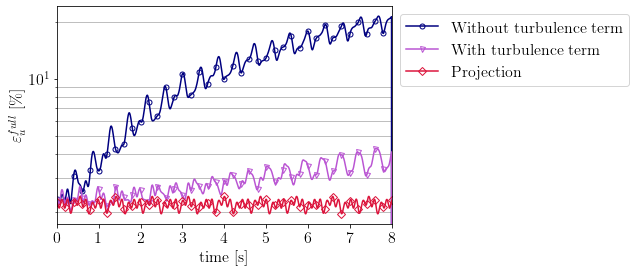

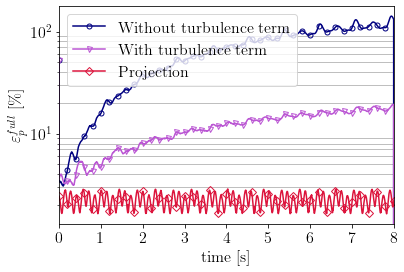

In [19]:
colors = ["royalblue","mediumorchid","crimson","lightseagreen","navy"]
markers = ["o","v","D","p","s"]
    
figvel2=plt.figure()
ax = figvel2.add_subplot(111)
plt.plot(ROM_case.errU_full, color=colors[0],marker=markers[0],markersize=5,markevery=50,label=r'Without turbulence term', fillstyle='none')
plt.plot(ROM_caseT.errU_full, color=colors[1],marker=markers[1],markersize=5,markevery=50,label=r'With turbulence term', fillstyle='none')
plt.plot(ROM_case_stand.errU_full, color=colors[2],marker=markers[2],markersize=5,markevery=50,label=r'Standard system', fillstyle='none')
plt.plot(U_err_proj, color=colors[3],marker=markers[3],markersize=5,markevery=50,label=r'Projection', fillstyle='none')
plt.ylabel(r'$\varepsilon_u^{full}$ [$\%$]')
ax.set_xticks([0,250,500,750,1000,1250,1500,1750,2000])
ax.set_xticklabels([0,1,2,3,4,5,6,7,8])
ax.set_xlabel('time [s]')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xlim(0,2000)
plt.yscale("log")
plt.grid(True, which="both", ls="-")
plt.grid()
plt.show()
figvel2.savefig("error_U.pdf",bbox_inches='tight')

figp=plt.figure()
ax = figp.add_subplot(111)
plt.plot(ROM_case.errP_full, color=colors[0],marker=markers[0],markersize=5,markevery=50,label=r'Without turbulence term', fillstyle='none')
plt.plot(ROM_caseT.errP_full, color=colors[1],marker=markers[1],markersize=5,markevery=50,label=r'With turbulence term', fillstyle='none')
plt.plot(ROM_caseT.errP_full, color=colors[2],marker=markers[2],markersize=5,markevery=50,label=r'Standard system', fillstyle='none')
plt.plot(P_err_proj, color=colors[3],marker=markers[3],markersize=5,markevery=50,label=r'Projection', fillstyle='none')
plt.ylabel(r'$\varepsilon_p^{full}$ [$\%$]')
ax.set_xticks([0,250,500,750,1000,1250,1500,1750,2000])
ax.set_xticklabels([0,1,2,3,4,5,6,7,8])
ax.set_xlabel('time [s]')
plt.legend()
plt.xlim(0,2000)
plt.yscale("log")
plt.grid(True, which="both", ls="-")
plt.grid()
plt.show()
figp.savefig("error_P.pdf",bbox_inches='tight')